# Feed Forward Network（FFN）デモ

このノートブックでは、Transformerにおける**Feed Forward Network**の仕組みを学びます。

## FFNの役割

Transformerの各層は2つの主要コンポーネントで構成されます：

1. **Multi-Head Attention**: トークン間の関係を捉える
2. **Feed Forward Network**: 各トークンの特徴を非線形変換する

```
入力 → Attention → FFN → 出力
        (線形)     (非線形)
```

FFNがなぜ必要か：
- Attentionは本質的に**線形変換**（重み付き和）
- FFNで**非線形性**を導入し、複雑なパターンを学習可能に

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from src.feed_forward import FeedForward, GatedFeedForward

# 日本語フォント設定（macOS）
plt.rcParams['font.family'] = 'Hiragino Sans'

# 再現性のためのシード設定
torch.manual_seed(42)

## 1. FFNの構造

論文 "Attention is All You Need" での定義：

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

つまり：
1. **拡大**: `d_model → d_ff`（通常4倍）
2. **活性化関数**: ReLU（または GELU）
3. **縮小**: `d_ff → d_model`

```
入力         1層目           活性化       2層目         出力
[d_model] → [d_ff=4×d_model] → ReLU → [d_model]
   64    →      256         →      →    64
```

In [2]:
# FFNの構造を確認

d_model = 64
d_ff = 256  # 4倍

ffn = FeedForward(d_model, d_ff, dropout=0.0, activation='relu')

print("Feed Forward Network の構造")
print("=" * 50)
print(ffn)
print()

# 各層の形状
print("各層のパラメータ形状:")
print(f"  linear1.weight: {ffn.linear1.weight.shape} (d_model→d_ff)")
print(f"  linear1.bias:   {ffn.linear1.bias.shape}")
print(f"  linear2.weight: {ffn.linear2.weight.shape} (d_ff→d_model)")
print(f"  linear2.bias:   {ffn.linear2.bias.shape}")

Feed Forward Network の構造
FeedForward(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (activation): ReLU()
)

各層のパラメータ形状:
  linear1.weight: torch.Size([256, 64]) (d_model→d_ff)
  linear1.bias:   torch.Size([256])
  linear2.weight: torch.Size([64, 256]) (d_ff→d_model)
  linear2.bias:   torch.Size([64])


In [3]:
# 順伝播の流れを追跡

batch_size = 1
seq_len = 5

x = torch.randn(batch_size, seq_len, d_model)

print("順伝播の流れ")
print("=" * 50)
print(f"入力:       {x.shape}")

# 手動で各ステップを実行
h1 = ffn.linear1(x)
print(f"1層目後:    {h1.shape}  (d_model={d_model} → d_ff={d_ff})")

h2 = ffn.activation(h1)
print(f"ReLU後:     {h2.shape}  (形状は同じ、負の値が0に)")

h3 = ffn.linear2(h2)
print(f"2層目後:    {h3.shape}  (d_ff={d_ff} → d_model={d_model})")

# 検証
output = ffn(x)
print(f"\n最終出力:   {output.shape}")
print(f"手動計算との差: {(output - h3).abs().max().item():.10f}")

順伝播の流れ
入力:       torch.Size([1, 5, 64])
1層目後:    torch.Size([1, 5, 256])  (d_model=64 → d_ff=256)
ReLU後:     torch.Size([1, 5, 256])  (形状は同じ、負の値が0に)
2層目後:    torch.Size([1, 5, 64])  (d_ff=256 → d_model=64)

最終出力:   torch.Size([1, 5, 64])
手動計算との差: 0.0000000000


## 2. なぜ中間層を拡大するのか？

FFNでは `d_model → d_ff (4倍) → d_model` と、一度次元を拡大してから縮小します。

**理由**: 表現力の向上

- 高次元空間でより複雑なパターンを捉える
- ReLUで多くのニューロンが活性化し、多様な特徴を表現
- 縮小時に重要な情報を圧縮・選択

In [4]:
# 拡大率による違いを確認

d_model = 64
expansion_ratios = [1, 2, 4, 8]

print("拡大率によるパラメータ数の変化")
print("=" * 50)

for ratio in expansion_ratios:
    d_ff = d_model * ratio
    ffn = FeedForward(d_model, d_ff, dropout=0.0)
    params = sum(p.numel() for p in ffn.parameters())
    print(f"拡大率 {ratio}x: d_ff={d_ff:4d}, パラメータ数={params:,}")

拡大率によるパラメータ数の変化
拡大率 1x: d_ff=  64, パラメータ数=8,320
拡大率 2x: d_ff= 128, パラメータ数=16,576
拡大率 4x: d_ff= 256, パラメータ数=33,088
拡大率 8x: d_ff= 512, パラメータ数=66,112


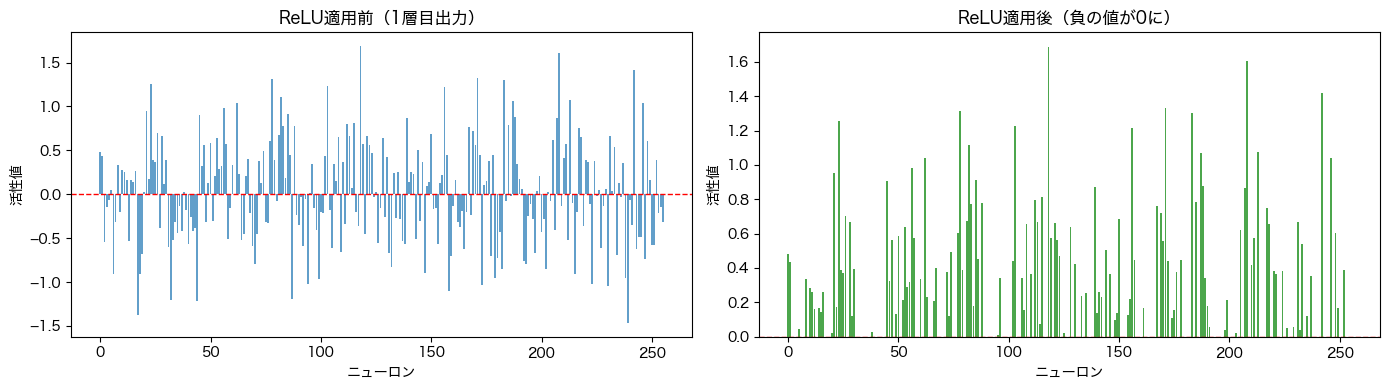

活性化されたニューロンの割合: 50.0%
（約半分が活性化されるのが典型的）


In [5]:
# ReLU活性化の効果を可視化

d_model = 64
d_ff = 256
ffn = FeedForward(d_model, d_ff, dropout=0.0, activation='relu')

x = torch.randn(1, 1, d_model)  # 1つのトークン

# 1層目の出力（活性化前後）
h_before = ffn.linear1(x).squeeze()
h_after = ffn.activation(h_before)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 活性化前
axes[0].bar(range(len(h_before)), h_before.detach().numpy(), alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[0].set_title('ReLU適用前（1層目出力）')
axes[0].set_xlabel('ニューロン')
axes[0].set_ylabel('活性値')

# 活性化後
axes[1].bar(range(len(h_after)), h_after.detach().numpy(), alpha=0.7, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1].set_title('ReLU適用後（負の値が0に）')
axes[1].set_xlabel('ニューロン')
axes[1].set_ylabel('活性値')

plt.tight_layout()
plt.show()

# 活性化されたニューロンの割合
active_ratio = (h_after > 0).float().mean().item()
print(f"活性化されたニューロンの割合: {active_ratio*100:.1f}%")
print(f"（約半分が活性化されるのが典型的）")

## 3. 活性化関数の比較: ReLU vs GELU

| 活性化関数 | 数式 | 使用モデル |
|-----------|------|------------|
| ReLU | max(0, x) | 元のTransformer |
| GELU | x × Φ(x) | BERT, GPT-2以降 |

GELUは滑らかな活性化関数で、勾配消失問題を軽減します。

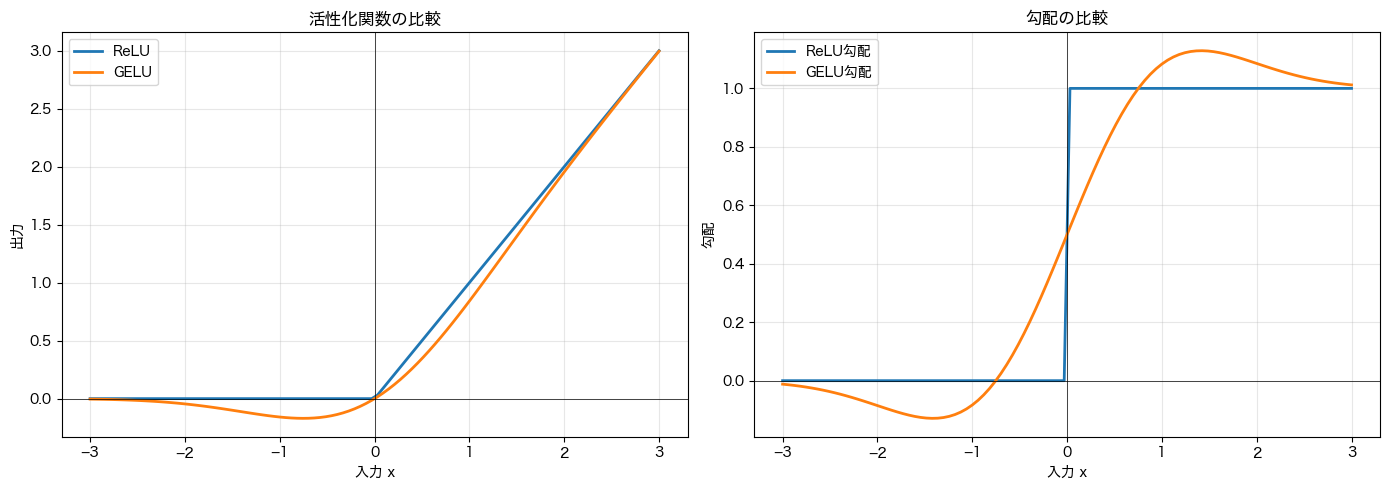

観察:
- ReLU: x=0で不連続な勾配（0 or 1）
- GELU: 滑らかな勾配、負の入力にも小さな勾配


In [6]:
# ReLU vs GELU の比較

x = torch.linspace(-3, 3, 100)

relu = nn.ReLU()
gelu = nn.GELU()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 活性化関数の形状
axes[0].plot(x.numpy(), relu(x).numpy(), label='ReLU', linewidth=2)
axes[0].plot(x.numpy(), gelu(x).numpy(), label='GELU', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('入力 x')
axes[0].set_ylabel('出力')
axes[0].set_title('活性化関数の比較')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 勾配の比較
x_grad = x.clone().requires_grad_(True)
relu_out = relu(x_grad)
relu_grad = torch.autograd.grad(relu_out.sum(), x_grad, create_graph=True)[0]

x_grad2 = x.clone().requires_grad_(True)
gelu_out = gelu(x_grad2)
gelu_grad = torch.autograd.grad(gelu_out.sum(), x_grad2, create_graph=True)[0]

axes[1].plot(x.numpy(), relu_grad.detach().numpy(), label='ReLU勾配', linewidth=2)
axes[1].plot(x.numpy(), gelu_grad.detach().numpy(), label='GELU勾配', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('入力 x')
axes[1].set_ylabel('勾配')
axes[1].set_title('勾配の比較')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("観察:")
print("- ReLU: x=0で不連続な勾配（0 or 1）")
print("- GELU: 滑らかな勾配、負の入力にも小さな勾配")

In [7]:
# FFNでの出力比較

d_model = 64
d_ff = 256

ffn_relu = FeedForward(d_model, d_ff, dropout=0.0, activation='relu')
ffn_gelu = FeedForward(d_model, d_ff, dropout=0.0, activation='gelu')

# 同じ重みを使用して比較
ffn_gelu.linear1.weight.data = ffn_relu.linear1.weight.data.clone()
ffn_gelu.linear1.bias.data = ffn_relu.linear1.bias.data.clone()
ffn_gelu.linear2.weight.data = ffn_relu.linear2.weight.data.clone()
ffn_gelu.linear2.bias.data = ffn_relu.linear2.bias.data.clone()

x = torch.randn(1, 10, d_model)

with torch.no_grad():
    out_relu = ffn_relu(x)
    out_gelu = ffn_gelu(x)

print("同じ重みでの出力比較（最初のトークン、最初の10次元）:")
print(f"ReLU: {out_relu[0, 0, :10].numpy()}")
print(f"GELU: {out_gelu[0, 0, :10].numpy()}")
print(f"\n差の絶対値の平均: {(out_relu - out_gelu).abs().mean().item():.4f}")

同じ重みでの出力比較（最初のトークン、最初の10次元）:
ReLU: [ 0.17577992  0.02394189 -0.37173694  0.33748478 -0.32233644 -0.17208174
  0.42193446  0.00379678  0.1014023  -0.06797353]
GELU: [ 0.26389366  0.0473938  -0.24891213  0.22449489 -0.18528779 -0.1602948
  0.35360864  0.02443072  0.06814227 -0.0227525 ]

差の絶対値の平均: 0.0561


## 4. Position-wise（位置ごと）とは？

FFNの重要な特徴は、**各位置（トークン）に独立に同じ変換を適用する**ことです。

```
トークン1 → FFN → 出力1
トークン2 → FFN → 出力2   (同じFFN)
トークン3 → FFN → 出力3   (同じFFN)
```

- **Attention**: トークン間の情報を交換
- **FFN**: 各トークンを独立に変換（位置間の交換なし）

In [8]:
# Position-wiseの確認

d_model = 64
ffn = FeedForward(d_model, dropout=0.0)

# 3つのトークンを持つシーケンス
x = torch.randn(1, 3, d_model)

# 全体を一度に処理
with torch.no_grad():
    output_batch = ffn(x)

# 各トークンを個別に処理
with torch.no_grad():
    output_0 = ffn(x[:, 0:1, :])
    output_1 = ffn(x[:, 1:2, :])
    output_2 = ffn(x[:, 2:3, :])
    output_individual = torch.cat([output_0, output_1, output_2], dim=1)

print("Position-wise（位置ごと）の確認")
print("=" * 50)
print(f"バッチ処理の出力形状: {output_batch.shape}")
print(f"個別処理の出力形状:   {output_individual.shape}")
print(f"\n両者の差: {(output_batch - output_individual).abs().max().item():.10f}")
print("→ 完全に一致！各位置が独立に処理されている")

Position-wise（位置ごと）の確認
バッチ処理の出力形状: torch.Size([1, 3, 64])
個別処理の出力形状:   torch.Size([1, 3, 64])

両者の差: 0.0000002980
→ 完全に一致！各位置が独立に処理されている


In [9]:
# Attentionとの比較

from src.attention import MultiHeadAttention

d_model = 64
num_heads = 4

mha = MultiHeadAttention(d_model, num_heads, dropout=0.0)
ffn = FeedForward(d_model, dropout=0.0)

x = torch.randn(1, 5, d_model)

print("AttentionとFFNの違い")
print("=" * 50)

# 位置1のトークンだけ変更
x_modified = x.clone()
x_modified[0, 1, :] = torch.randn(d_model)  # 位置1を変更

with torch.no_grad():
    # Attention
    attn_out_orig, _ = mha(x, x, x)
    attn_out_mod, _ = mha(x_modified, x_modified, x_modified)
    
    # FFN
    ffn_out_orig = ffn(x)
    ffn_out_mod = ffn(x_modified)

print("位置1のトークンを変更した場合:")
print()
print("【Attention】")
for pos in range(5):
    diff = (attn_out_orig[0, pos] - attn_out_mod[0, pos]).abs().mean().item()
    print(f"  位置{pos}の出力変化: {diff:.4f}")

print()
print("【FFN】")
for pos in range(5):
    diff = (ffn_out_orig[0, pos] - ffn_out_mod[0, pos]).abs().mean().item()
    print(f"  位置{pos}の出力変化: {diff:.4f}")

print()
print("観察:")
print("- Attention: 位置1の変更が全位置に影響")
print("- FFN: 位置1の変更は位置1の出力にのみ影響")

AttentionとFFNの違い
位置1のトークンを変更した場合:

【Attention】
  位置0の出力変化: 0.0873
  位置1の出力変化: 0.1025
  位置2の出力変化: 0.0810
  位置3の出力変化: 0.0741
  位置4の出力変化: 0.0814

【FFN】
  位置0の出力変化: 0.0000
  位置1の出力変化: 0.2082
  位置2の出力変化: 0.0000
  位置3の出力変化: 0.0000
  位置4の出力変化: 0.0000

観察:
- Attention: 位置1の変更が全位置に影響
- FFN: 位置1の変更は位置1の出力にのみ影響


## 5. Gated FFN（SwiGLU）

最新のLLM（LLaMA, PaLMなど）では、**ゲート機構**付きのFFNが使われています：

$$\text{FFN}_{\text{SwiGLU}}(x) = (xW_1 \odot \text{SiLU}(xW_{\text{gate}})) W_2$$

- $\odot$: element-wise乗算
- SiLU: Swish活性化関数（$x \cdot \sigma(x)$）

ゲートにより、情報の流れを動的に制御します。

In [10]:
# Gated FFNの構造

d_model = 64
d_ff = 256

gated_ffn = GatedFeedForward(d_model, d_ff, dropout=0.0)

print("Gated Feed Forward Network の構造")
print("=" * 50)
print(gated_ffn)
print()

print("各層のパラメータ形状:")
print(f"  w1.weight:     {gated_ffn.w1.weight.shape} (d_model→d_ff)")
print(f"  w_gate.weight: {gated_ffn.w_gate.weight.shape} (d_model→d_ff, ゲート用)")
print(f"  w2.weight:     {gated_ffn.w2.weight.shape} (d_ff→d_model)")

Gated Feed Forward Network の構造
GatedFeedForward(
  (w1): Linear(in_features=64, out_features=256, bias=False)
  (w2): Linear(in_features=256, out_features=64, bias=False)
  (w_gate): Linear(in_features=64, out_features=256, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (silu): SiLU()
)

各層のパラメータ形状:
  w1.weight:     torch.Size([256, 64]) (d_model→d_ff)
  w_gate.weight: torch.Size([256, 64]) (d_model→d_ff, ゲート用)
  w2.weight:     torch.Size([64, 256]) (d_ff→d_model)


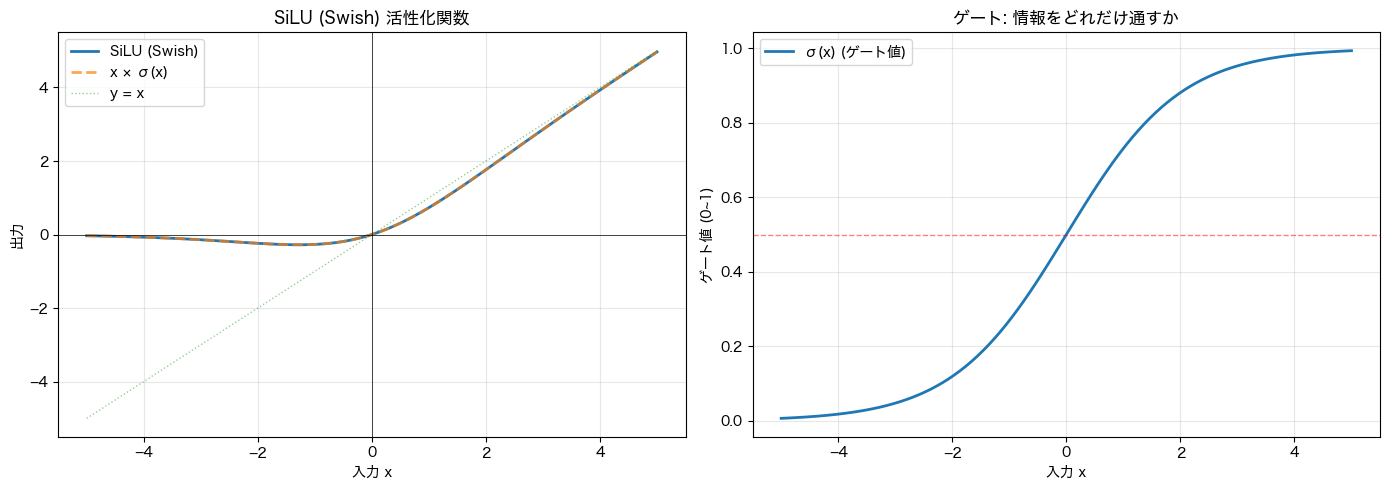

SiLUの特徴:
- 負の入力に対しても小さな負の値を出力（ReLUと異なり完全に0にしない）
- 滑らかな勾配で学習が安定


In [11]:
# SiLU活性化関数の可視化

x = torch.linspace(-5, 5, 100)

silu = nn.SiLU()
sigmoid = nn.Sigmoid()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SiLU = x * sigmoid(x)
axes[0].plot(x.numpy(), silu(x).numpy(), label='SiLU (Swish)', linewidth=2)
axes[0].plot(x.numpy(), x.numpy() * sigmoid(x).numpy(), '--', label='x × σ(x)', linewidth=2, alpha=0.7)
axes[0].plot(x.numpy(), x.numpy(), ':', label='y = x', linewidth=1, alpha=0.5)
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('入力 x')
axes[0].set_ylabel('出力')
axes[0].set_title('SiLU (Swish) 活性化関数')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ゲート機構のイメージ
axes[1].plot(x.numpy(), sigmoid(x).numpy(), label='σ(x) (ゲート値)', linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('入力 x')
axes[1].set_ylabel('ゲート値 (0~1)')
axes[1].set_title('ゲート: 情報をどれだけ通すか')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SiLUの特徴:")
print("- 負の入力に対しても小さな負の値を出力（ReLUと異なり完全に0にしない）")
print("- 滑らかな勾配で学習が安定")

In [12]:
# 標準FFN vs Gated FFNのパラメータ比較

d_model = 512  # 実際のTransformerでよく使われる値
d_ff = 2048

standard_ffn = FeedForward(d_model, d_ff, dropout=0.0)
gated_ffn = GatedFeedForward(d_model, d_ff, dropout=0.0)

standard_params = sum(p.numel() for p in standard_ffn.parameters())
gated_params = sum(p.numel() for p in gated_ffn.parameters())

print("パラメータ数の比較 (d_model=512, d_ff=2048)")
print("=" * 50)
print(f"標準FFN:  {standard_params:,} パラメータ")
print(f"  - linear1: {d_model}×{d_ff} + {d_ff} = {d_model*d_ff + d_ff:,}")
print(f"  - linear2: {d_ff}×{d_model} + {d_model} = {d_ff*d_model + d_model:,}")
print()
print(f"Gated FFN: {gated_params:,} パラメータ")
print(f"  - w1:     {d_model}×{d_ff} = {d_model*d_ff:,}")
print(f"  - w_gate: {d_model}×{d_ff} = {d_model*d_ff:,}")
print(f"  - w2:     {d_ff}×{d_model} = {d_ff*d_model:,}")
print()
print(f"比率: Gated / Standard = {gated_params / standard_params:.2f}x")
print("\n→ Gated FFNは約1.5倍のパラメータだが、性能向上が報告されている")

パラメータ数の比較 (d_model=512, d_ff=2048)
標準FFN:  2,099,712 パラメータ
  - linear1: 512×2048 + 2048 = 1,050,624
  - linear2: 2048×512 + 512 = 1,049,088

Gated FFN: 3,145,728 パラメータ
  - w1:     512×2048 = 1,048,576
  - w_gate: 512×2048 = 1,048,576
  - w2:     2048×512 = 1,048,576

比率: Gated / Standard = 1.50x

→ Gated FFNは約1.5倍のパラメータだが、性能向上が報告されている


## 6. FFNのパラメータ数

Transformerにおいて、FFNはパラメータの大部分を占めます。

1層あたりのパラメータ配分 (d_model=512, d_ff=2048)
Multi-Head Attention: 1,048,576 (33.3%)
Feed Forward Network: 2,099,712 (66.7%)
合計: 3,148,288


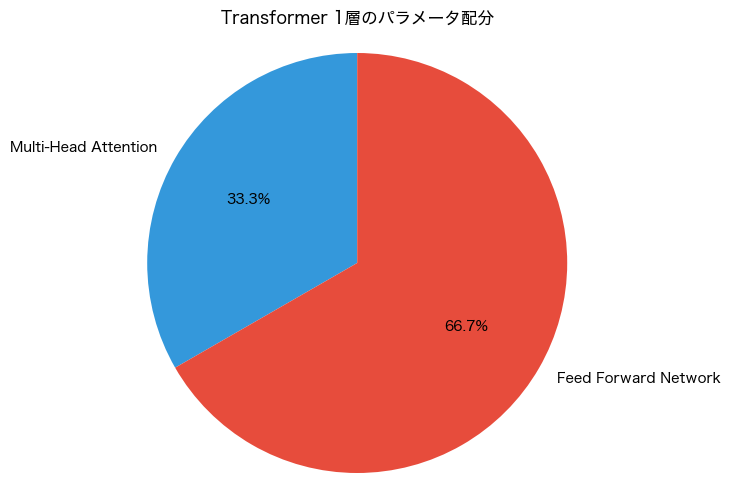


→ FFNがパラメータの約2/3を占める！


In [13]:
# Transformerにおけるパラメータ配分

d_model = 512
d_ff = 2048  # 4倍
num_heads = 8

# Multi-Head Attention
mha = MultiHeadAttention(d_model, num_heads, dropout=0.0)
mha_params = sum(p.numel() for p in mha.parameters())

# Feed Forward
ffn = FeedForward(d_model, d_ff, dropout=0.0)
ffn_params = sum(p.numel() for p in ffn.parameters())

total = mha_params + ffn_params

print("1層あたりのパラメータ配分 (d_model=512, d_ff=2048)")
print("=" * 50)
print(f"Multi-Head Attention: {mha_params:,} ({mha_params/total*100:.1f}%)")
print(f"Feed Forward Network: {ffn_params:,} ({ffn_params/total*100:.1f}%)")
print(f"合計: {total:,}")

# 可視化
plt.figure(figsize=(8, 6))
labels = ['Multi-Head Attention', 'Feed Forward Network']
sizes = [mha_params, ffn_params]
colors = ['#3498db', '#e74c3c']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Transformer 1層のパラメータ配分')
plt.axis('equal')
plt.show()

print("\n→ FFNがパラメータの約2/3を占める！")

## 7. まとめ

### Feed Forward Networkの役割
- Attentionで集約した情報を**非線形変換**
- 各位置（トークン）に**独立に**適用（Position-wise）

### 構造
```
入力[d_model] → 拡大[d_ff=4×d_model] → 活性化 → 縮小[d_model] → 出力
```

### 活性化関数
| 活性化関数 | 特徴 | 使用例 |
|-----------|------|--------|
| ReLU | シンプル | 元のTransformer |
| GELU | 滑らか | BERT, GPT |
| SwiGLU | ゲート機構 | LLaMA, PaLM |

### 次のステップ
- Layer Normalization
- Residual Connection
- Encoderブロック全体の構築

In [14]:
# 学習パラメータの確認

print("Feed Forward Network パラメータ一覧")
print("=" * 50)

d_model = 64
d_ff = 256

print("\n【標準 FFN (ReLU)】")
ffn = FeedForward(d_model, d_ff)
for name, param in ffn.named_parameters():
    print(f"  {name}: {param.shape} = {param.numel():,} params")
print(f"  合計: {sum(p.numel() for p in ffn.parameters()):,} params")

print("\n【Gated FFN (SwiGLU)】")
gated = GatedFeedForward(d_model, d_ff)
for name, param in gated.named_parameters():
    print(f"  {name}: {param.shape} = {param.numel():,} params")
print(f"  合計: {sum(p.numel() for p in gated.parameters()):,} params")

Feed Forward Network パラメータ一覧

【標準 FFN (ReLU)】
  linear1.weight: torch.Size([256, 64]) = 16,384 params
  linear1.bias: torch.Size([256]) = 256 params
  linear2.weight: torch.Size([64, 256]) = 16,384 params
  linear2.bias: torch.Size([64]) = 64 params
  合計: 33,088 params

【Gated FFN (SwiGLU)】
  w1.weight: torch.Size([256, 64]) = 16,384 params
  w2.weight: torch.Size([64, 256]) = 16,384 params
  w_gate.weight: torch.Size([256, 64]) = 16,384 params
  合計: 49,152 params
